In [112]:
def load_lerc_preds(dev_df):
    with open("../outputs/experiment/preds/LERC-dev_preds.json", "r") as f:
        data = json.load(f)


    results = []
    for dataset, d in data.items():
        for example_id, scores in d.items():
            results.append({
                "dataset": dataset,
                "example_id": example_id,
                "LERC_original": scores["pred_score"],
                "LERC": (scores["pred_score"] - 1) / (5-1)
            })

    dev_df = dev_df.copy().set_index(["dataset", "example_id"]).join(pd.DataFrame(results).set_index(["dataset", "example_id"])).reset_index()
    
    return dev_df

## Regression

Train and evaluate the baselines. Baselines are: 

- Linear Regression
- L1 regression (Lasso Regression)
- Decision Tree 
- Random Forests 

For every baseline above (except L1), we'll also consider a PCA version where we first reduce the dimensionality. 

In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

METRICS_DIR = "../outputs/metrics/proxy_metrics_20220426"

# ---------------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------------
TRAIN_FILEPATH = f"{METRICS_DIR}/train_all_datasets_metrics.csv.gz"
DEV_FILEPATH = f"{METRICS_DIR}/dev_all_datasets_metrics.csv.gz"

train_df = pd.read_csv(TRAIN_FILEPATH, index_col=0)
print(f"Read dataset with {len(train_df)} examples from {TRAIN_FILEPATH}")

dev_df = pd.read_csv(DEV_FILEPATH, index_col=0)
print(f"Read (holdout) dataset with {len(dev_df)} examples from {DEV_FILEPATH}")

# ---------------------------------------------------------------
# FEATURES and TARGET 
# ---------------------------------------------------------------
METRIC_COLS = train_df.select_dtypes("number").columns
features = list(METRIC_COLS[2:])

# Add lerc_preds after selecting features to avoid using them in our models
dev_df = load_lerc_preds(dev_df)

# Target column will be the normalized human correctness
target = METRIC_COLS[1]
print("Features:\t", features, "\n\nTarget:\t", target)
      
DATASET_NAMES = sorted(train_df["dataset"].unique())

TRAIN_DATASETS = {"all": train_df}
TRAIN_DATASETS.update({d: train_df[train_df["dataset"] == d] for d in DATASET_NAMES})

EVAL_DATASETS = {"all": dev_df}
EVAL_DATASETS.update({d: dev_df[dev_df["dataset"] == d] for d in DATASET_NAMES})

Read dataset with 31069 examples from ../outputs/metrics/proxy_metrics_20220426/train_all_datasets_metrics.csv.gz
Read (holdout) dataset with 4009 examples from ../outputs/metrics/proxy_metrics_20220426/dev_all_datasets_metrics.csv.gz
Features:	 ['exact_match', 'meteor', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleurt', 'bert-score', 'bleu1', 'bleu2', 'bleu3', 'bleu4', 'bleu-precision0', 'bleu-precision1', 'bleu-precision2', 'bleu-precision3', 'precision', 'recall', 'f1_score', 'csi', 'num_edits', 'edit_score'] 

Target:	 human_correctness


In [114]:
features

['exact_match',
 'meteor',
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'bleurt',
 'bert-score',
 'bleu1',
 'bleu2',
 'bleu3',
 'bleu4',
 'bleu-precision0',
 'bleu-precision1',
 'bleu-precision2',
 'bleu-precision3',
 'precision',
 'recall',
 'f1_score',
 'csi',
 'num_edits',
 'edit_score']

TODO 
- [ ] Compute Baselines (Avg metric)
- [ ] Compute Linear Regression 
- [ ] L1 regression
- [ ] Decision Tree
- [ ] Random Forest
- 

In [115]:
class NoPreprocessing:
    def fit(self, *args, **kwargs): 
        pass
    
    def transform(self, X, *args, **kwargs): 
        return X
    
    def fit_transform(self, X, *args, **kwargs): 
        return X
    

class Pipeline:
    """"""
    
    def __init__(self, model_class, model_hparams, dataset, features, target, seed=81263):
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.dataset = dataset
        self.features = features
        self.target = target
        self.seed = seed
        
    def load_data(self, data):
        """"""
        print(f"Loading dataset '{self.dataset}'")
        if self.dataset == "all":
            data = data.copy()
        else:
            data = data[data["dataset"] == self.dataset].copy()

        self.X_train = data[self.features]
        self.y_train = data[self.target]
        
    def split(self, holdout_fraction=0.2):
        """"""
        # print(f"Splitting dataset holdout_fraction={holdout_fraction}")
        from sklearn.model_selection import train_test_split
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_train, self.y_train,
            test_size=holdout_fraction, 
            random_state=self.seed, 
            stratify=self.y_train,
        )
            
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test        
        
    def preprocess(self, with_std=True, with_pca=False, **kwargs):
        """"""
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import make_pipeline
        from sklearn.decomposition import PCA
        
        operations = []
        
        if with_std:
            # print("Using StandardScaler")
            operations.append(StandardScaler())
        if with_pca:
            print("Using PCA")
            operations.append(PCA(random_state=self.seed, **kwargs))
        
        self.preproc_fn = make_pipeline(*operations) \
            if len(operations) > 0 else NoPreprocessing()
        
        self.preproc_fn.fit(self.X_train)
        self.X_train = self.preproc_fn.transform(self.X_train)
        
        if getattr(self, "X_test", None) is not None:
            self.X_test = self.preproc_fn.transform(self.X_test)
        
    def fit(self):
        """"""
        self.model = self.model_class(**self.model_hparams)
        self.model.fit(self.X_train, self.y_train)
        
    def evaluate(self, eval_dataset=None):
        """"""
        import sklearn.metrics as m
        import scipy.stats as st
        
        if eval_dataset is None:
            # print("Evaluating holdout dev set.")
            X_test, y_test = self.X_test, self.y_test
        else:
            X_test = eval_dataset[self.features]
            y_test = eval_dataset[self.target]    
            X_test = self.preproc_fn.transform(X_test)
        
        # Evaluation
        scores = self.model.predict(X_test)
        
        return {
            "mse": m.mean_squared_error(y_pred=scores, y_true=y_test),
            "r2": m.r2_score(y_pred=scores, y_true=y_test),
            "pearson": st.pearsonr(scores, y_test)[0],
            "spearman": st.spearmanr(scores, y_test)[0],
            "trained_on": self.dataset,
        }
        
    def evaluate_multiple(self, eval_datasets: dict):
        all_results = []
        
        for name, eval_dataset in eval_datasets.items():
            eval_result = self.evaluate(eval_dataset)
            eval_result["evaluated_on"] = name
            all_results.append(eval_result)
            
        return all_results


from functools import partial

# Abstract features and targets
general_pipeline = partial(Pipeline, features=features, target=target)

## Apply preprocessing to train_data

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = train_test_split(train_df, test_size=0.15, random_state=1231331, stratify=train_df[target])
train_data, test_data = data
len(train_data), len(test_data)

scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])



def write_to_json(data, filepath):
    from collections import defaultdict
    final_dataset = defaultdict(dict)

    for ix, example in data.iterrows():
        example = example.to_dict().copy()
        dataset = example.pop("dataset")
        example_id = example.pop("example_id")

        final_dataset[dataset][example_id] = example

    with open(filepath, "w", encoding='utf-8') as f:
        json.dump(final_dataset, f, indent=2, ensure_ascii=False)
        
        
import joblib
joblib.dump(scaler, "../data/metric-modeling/preproc/train_test_015_1231331_scaler.bin")

train_preproc_filepath = "../data/metric-modeling/preproc/train_split_test_015_1231331.json"
dev_preproc_filepath = "../data/metric-modeling/preproc/dev_split_test_015_1231331.json"
write_to_json(train_data, train_preproc_filepath)
write_to_json(test_data, dev_preproc_filepath)

In [191]:
ORIGINAL_DIR = "/home/kat/Projects/PhD/qasper-experiments/eqqa/data/mocha"
PREPROC_DIR = "../data/metric-modeling/preproc"

orig_data = json.load(open(ORIGINAL_DIR + "/train.json"))
preproc_train_data = json.load(open(PREPROC_DIR + "/train_split_test_015_1231331.json"))
preproc_dev_data = json.load(open(PREPROC_DIR + "/dev_split_test_015_1231331.json"))

for dataset, examples in orig_data.items():
    for example_id, example in examples.items():
        if preproc_train_data[dataset].get(example_id, False):
            new_example = preproc_train_data[dataset][example_id]
        elif preproc_dev_data[dataset].get(example_id, False):
            new_example = preproc_dev_data[dataset][example_id]
        else:
            raise ValueError(f"Invalid id: {example_id}")

        new_example["context"] = example["context"]
        new_example["question"] = example["question"]
        
        

with open(PREPROC_DIR + "/train_split_test_015_1231331_w_context.json", "w") as f:
    json.dump(preproc_train_data, f, indent=2)
    
with open(PREPROC_DIR + "/dev_split_test_015_1231331_w_context.json", "w") as f:
    json.dump(preproc_dev_data, f, indent=2)

In [116]:
def run_model_selection(model_class, model_hyperparams={}, train_datasets=TRAIN_DATASETS, pipeline=None):
    pipelines = {}
    all_results = []
    for train_name, train_data in train_datasets.items(): 
        if pipeline is None:
            p = general_pipeline(model_class, model_hyperparams, dataset=train_name)
        else:
            p = pipeline(model_class, model_hyperparams, dataset=train_name)
            
        p.load_data(train_data)
        p.split(holdout_fraction=0.2)
        p.preprocess(with_std=True)
        p.fit()
        
        result = p.evaluate()
        result["model_class"] = model_class.__name__
        result["model_hyperparams"] = st(rmodel_hyperparams)
        
        pipelines[train_name] = p
        all_results.append(result)

    return pd.DataFrame(all_results), pipelines


def run_eval(model_class, model_hyperparams={}, train_datasets=TRAIN_DATASETS, eval_datasets=EVAL_DATASETS, pipeline=None):
                           
    all_results = []
    pipelines = []
    for train_name, train_data in train_datasets.items(): 
        if pipeline is None:
            p = general_pipeline(model_class, model_hyperparams, dataset=train_name)
        else:
            p = pipeline(model_class, model_hyperparams, dataset=train_name)
            
        p.load_data(train_data)
        # p.split(holdout_fraction=0.2)
        # ^Note: We want to train with the whole training data when evaluating
        p.preprocess(with_std=True)
        p.fit()
        all_results.extend(p.evaluate_multiple(eval_datasets))
        pipelines.append(p)

    return pd.DataFrame(all_results), pipelines

In [5]:
# Linear regression
from sklearn.linear_model import LinearRegression
run_model_selection(LinearRegression)[0]

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


,mse,r2,pearson,spearman,trained_on,model_class,model_hyperparams
0,0.093295,0.414422,0.643876,0.641206,all,LinearRegression,{}
1,0.050313,0.678596,0.823920,0.761769,cosmosqa,LinearRegression,{}
2,0.072685,0.432717,0.664384,0.674960,drop,LinearRegression,{}
3,0.110449,0.356385,0.597036,0.594506,mcscript,LinearRegression,{}
4,0.108332,0.373252,0.611243,0.612935,narrativeqa,LinearRegression,{}
5,0.042555,0.534231,0.732197,0.721967,quoref,LinearRegression,{}
6,0.070787,0.536266,0.732457,0.721446,socialiqa,LinearRegression,{}


Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'



 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LASSO REGRESSION
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset '

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'm

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading datas

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading da

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


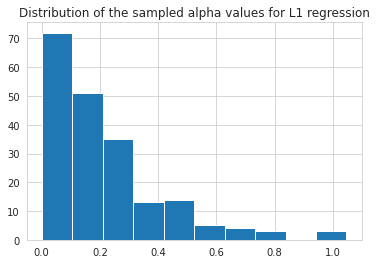

In [6]:
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


results = []

# -------------------------------------------
# Linear regression
# -------------------------------------------
rs = run_model_selection(LinearRegression)[0]
results.append(rs)


# -------------------------------------------
# Lasso regression
# -------------------------------------------
print("\n"*3,"+" * 80); print("LASSO REGRESSION"); print("+" * 80)
from sklearn.model_selection import ParameterSampler
from scipy.stats import expon
N_L1_MODELS = 200

l1_param_grid = {'alpha': expon(loc=0, scale=0.20)}
l1_param_list = list(ParameterSampler(l1_param_grid, n_iter=N_L1_MODELS, random_state=1234))

l1_pipelines = {}
for i, l1_hyperparams in enumerate(l1_param_list):
    if l1_hyperparams["alpha"] > 2: 
        print("Skipped example...")
        continue

    rs, ps = run_model_selection(Lasso, l1_hyperparams)
    rs["i"] = i
    results.append(rs)
    l1_pipelines[i] = ps
    
plt.hist([p["alpha"] for p in l1_param_list])
plt.title("Distribution of the sampled alpha values for L1 regression")
plt.show()

# -------------------------------------------
# Random forests regression
# -------------------------------------------
# print("\n"*3,"+" * 80); print("Random Forests"); print("+" * 80)
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import expon
# N_L1_MODELS = 200


results = pd.concat(results)

In [7]:
def get_alpha(args):
    return eval(args)["alpha"]

In [8]:
lasso_results = results[ (results.model_class == "Lasso")].copy().reset_index(drop=True)
lasso_results["alpha"] = lasso_results["model_hyperparams"].apply(get_alpha)
# lasso_results["no_metrics"] = lasso_results["pearson"].isna()

lasso_results

,mse,r2,pearson,spearman,trained_on,model_class,model_hyperparams,i,alpha
0,0.101457,3.631893e-01,0.613167,0.599964,all,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520
1,0.055585,6.449182e-01,0.812121,0.751868,cosmosqa,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520
2,0.076233,4.050255e-01,0.644595,0.701334,drop,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520
3,0.128120,2.534131e-01,0.510342,0.509626,mcscript,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520
4,0.117072,3.226882e-01,0.575158,0.580984,narrativeqa,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520
...,...,...,...,...,...,...,...,...,...
1395,0.128132,-3.470053e-05,NaN,NaN,drop,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106
1396,0.171608,-3.940903e-07,NaN,NaN,mcscript,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106
1397,0.172847,-1.565743e-07,NaN,NaN,narrativeqa,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106
1398,0.091365,-2.462531e-06,NaN,NaN,quoref,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106


['exact_match',
 'meteor',
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'bleurt',
 'bert-score',
 'bleu1',
 'bleu2',
 'bleu3',
 'bleu4',
 'bleu-precision0',
 'bleu-precision1',
 'bleu-precision2',
 'bleu-precision3',
 'precision',
 'recall',
 'f1_score',
 'csi',
 'num_edits',
 'edit_score']

In [239]:
from collections import defaultdict

_n_features = defaultdict(lambda: defaultdict(list))
_n_features_names = defaultdict(set)

for i, dataset_pipelines in l1_pipelines.items():
    for dataset, pipeline in dataset_pipelines.items():
        _feat_importance = pipeline.model.coef_
        _n_feats = sum(np.abs(_feat_importance) > 1e-5)
        lasso_results.loc[
            (lasso_results["i"] == i) & (lasso_results["trained_on"] == dataset)
            , "n_features"
        ] = _n_feats
        
        _feats = np.argsort(_feat_importance)
        _feats = {features[i]: _feat_importance[i] for i in _feats}
        _n_features[dataset][_n_feats].append(_feats)
        
        _mask = np.abs(_feat_importance) > 1e-5
        _n_features_names[dataset].add(tuple(features[i] for i, e in enumerate(_mask) if e))
        
        lasso_results.loc[
            (lasso_results["i"] == i) & (lasso_results["trained_on"] == dataset)
            , "feat_importance"
        ] = str(_feats)

lasso_results

,mse,r2,pearson,spearman,trained_on,model_class,model_hyperparams,i,alpha,n_features,feat_importance
0,0.101457,3.631893e-01,0.613167,0.599964,all,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520,3.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
1,0.055585,6.449182e-01,0.812121,0.751868,cosmosqa,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520,2.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
2,0.076233,4.050255e-01,0.644595,0.701334,drop,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520,2.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
3,0.128120,2.534131e-01,0.510342,0.509626,mcscript,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520,3.0,"{'exact_match': -0.0, 'csi': 0.0, 'f1_score': ..."
4,0.117072,3.226882e-01,0.575158,0.580984,narrativeqa,Lasso,{'alpha': 0.04251973152369602},0.0,0.042520,3.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
...,...,...,...,...,...,...,...,...,...,...,...
1395,0.128132,-3.470053e-05,NaN,NaN,drop,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106,0.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
1396,0.171608,-3.940903e-07,NaN,NaN,mcscript,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106,0.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
1397,0.172847,-1.565743e-07,NaN,NaN,narrativeqa,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106,0.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."
1398,0.091365,-2.462531e-06,NaN,NaN,quoref,Lasso,{'alpha': 0.5821063718279893},199.0,0.582106,0.0,"{'exact_match': 0.0, 'csi': 0.0, 'f1_score': 0..."


In [248]:
for dataset in DATASET_NAMES:
    print("\n\n", dataset, sorted(_n_features_names[dataset], key=len))



 cosmosqa [(), ('bleurt',), ('bleurt', 'bert-score'), ('bleurt', 'bert-score', 'bleu-precision2'), ('bleurt', 'bert-score', 'bleu-precision2', 'num_edits', 'edit_score'), ('bleurt', 'bert-score', 'bleu-precision0', 'bleu-precision2', 'precision', 'recall', 'num_edits', 'edit_score'), ('rouge1', 'bleurt', 'bert-score', 'bleu1', 'bleu-precision0', 'bleu-precision2', 'precision', 'recall', 'csi', 'num_edits', 'edit_score'), ('exact_match', 'rouge1', 'bleurt', 'bert-score', 'bleu1', 'bleu2', 'bleu-precision0', 'bleu-precision2', 'precision', 'recall', 'csi', 'num_edits', 'edit_score')]


 drop [(), ('rougeL',), ('meteor', 'rougeL'), ('meteor', 'rougeL', 'bleu-precision1'), ('meteor', 'rougeL', 'bleu4', 'bleu-precision1'), ('meteor', 'rougeL', 'bleurt', 'bleu4', 'bleu-precision1'), ('meteor', 'rougeL', 'bleurt', 'bert-score', 'bleu4', 'bleu-precision1'), ('meteor', 'rougeL', 'bleurt', 'bert-score', 'bleu4', 'bleu-precision1', 'bleu-precision2'), ('meteor', 'rougeL', 'bleurt', 'bert-score'

In [230]:
_n_features["quoref"][1]

[{'exact_match': 0.0,
  'csi': 0.0,
  'f1_score': 0.0,
  'recall': 0.0,
  'precision': 0.0,
  'bleu-precision3': 0.0,
  'bleu-precision2': 0.0,
  'bleu-precision1': 0.0,
  'bleu-precision0': 0.0,
  'bleu4': 0.0,
  'bleu3': 0.0,
  'bleu2': 0.0,
  'bleu1': 0.0,
  'bert-score': 0.0,
  'bleurt': 0.0,
  'rougeLsum': 0.0,
  'rougeL': 0.0,
  'rouge2': 0.0,
  'meteor': 0.0,
  'num_edits': -0.0,
  'edit_score': -0.0,
  'rouge1': 0.02456588223863958},
 {'exact_match': 0.0,
  'csi': 0.0,
  'f1_score': 0.0,
  'recall': 0.0,
  'precision': 0.0,
  'bleu-precision3': 0.0,
  'bleu-precision2': 0.0,
  'bleu-precision1': 0.0,
  'bleu-precision0': 0.0,
  'bleu4': 0.0,
  'bleu3': 0.0,
  'bleu2': 0.0,
  'bleu1': 0.0,
  'bert-score': 0.0,
  'bleurt': 0.0,
  'rougeLsum': 0.0,
  'rougeL': 0.0,
  'rouge2': 0.0,
  'meteor': 0.0,
  'num_edits': -0.0,
  'edit_score': -0.0,
  'rouge1': 0.1040418387614517},
 {'exact_match': 0.0,
  'csi': 0.0,
  'f1_score': 0.0,
  'recall': 0.0,
  'precision': 0.0,
  'bleu-precision

In [217]:
_n_features["narrativeqa"].keys()

dict_keys([3, 1, 0, 12, 6, 4, 8, 2, 15, 16, 9, 7])

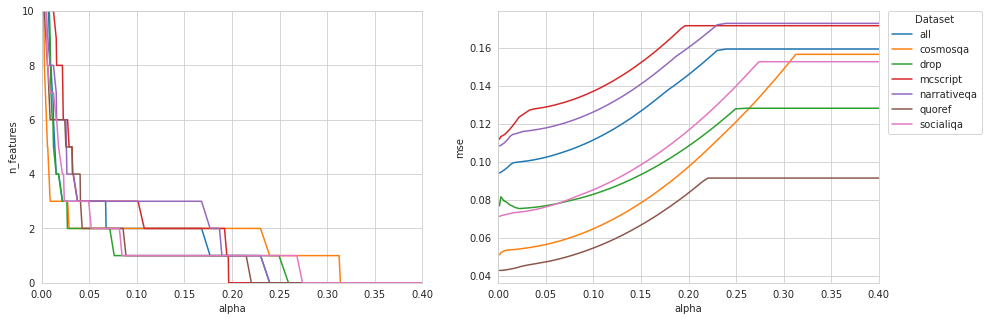

In [192]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
sns.lineplot(data=lasso_results, x="alpha", y="n_features", hue="trained_on", ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_ylim(0, 10)
axes[0].set_xlim(0, 0.4)
sns.lineplot(data=lasso_results, x="alpha", y="mse", hue="trained_on", ax=axes[1])

plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")
plt.show()

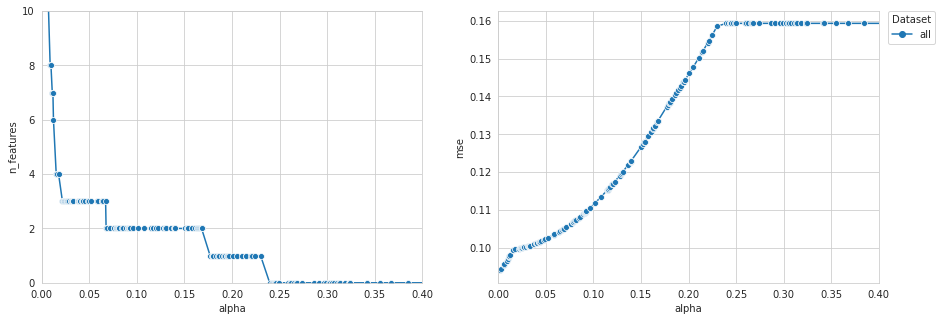

In [86]:
trained_on_all = lasso_results[lasso_results["trained_on"] == "all"]
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
sns.lineplot(data=trained_on_all, x="alpha", y="n_features", hue="trained_on", ax=axes[0], style="trained_on", markers=["o"])
axes[0].get_legend().remove()
axes[0].set_ylim(0, 10)
axes[0].set_xlim(0, 0.4)
sns.lineplot(data=trained_on_all, x="alpha", y="mse", hue="trained_on", ax=axes[1], style="trained_on", markers=["o"])

plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")
plt.show()

(0.0, 10.0)

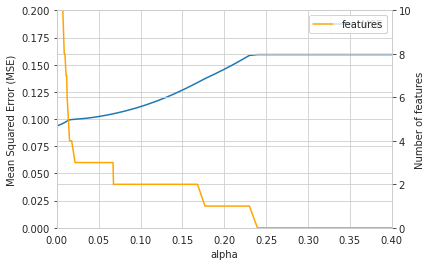

In [107]:
trained_on_all = lasso_results[lasso_results["trained_on"] == "all"]
sns.lineplot(data=trained_on_all, x="alpha", y="mse", label="MSE")
plt.ylabel("Mean Squared Error (MSE)")
plt.ylim(0, 0.2)
plt.xlim(0, 0.4)
ax2 = plt.twinx()
sns.lineplot(data=trained_on_all, x="alpha", y=trained_on_all["n_features"], label="features", color="orange", ax=ax2)
ax2.set_ylabel("Number of features")
ax2.set_ylim(0, 10)
# plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")


In [12]:
trained_on_all[trained_on_all.n_features == 4]

,mse,r2,pearson,spearman,trained_on,model_class,model_hyperparams,i,alpha,n_features
154,0.099347,0.376432,0.614815,0.602307,all,Lasso,{'alpha': 0.015674755911139815},22.0,0.015675,4.0
896,0.099300,0.376727,0.614983,0.602509,all,Lasso,{'alpha': 0.0152342600373696},128.0,0.015234,4.0
1008,0.099579,0.374980,0.613988,0.601341,all,Lasso,{'alpha': 0.017716815711522563},144.0,0.017717,4.0


Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'


<AxesSubplot:>

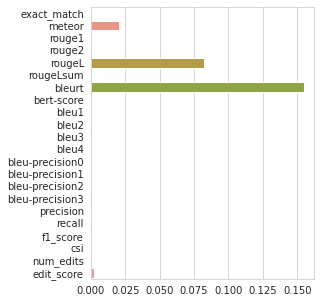

In [13]:
rs, ps = run_model_selection(Lasso, {'alpha': 0.017})

plt.figure(figsize=(4, 5))
feat_importance = ps["all"].model.coef_
sns.barplot(y=features, x=feat_importance, orient="h")

In [108]:
dev_df[target].mean(), ps["all"].model.intercept_

(0.3393094703583604, 0.3604405552202776)

In [77]:
class AvgBaseline:
    def __init__(self, features=None, subset=None):
        if features is None or subset is None:
            self.features = None
            self.subset = None
            self.subset_feat_ids = None
        else:
            self.features = features
            self.subset = subset        
            self.subset_feat_ids = [i for i, f in enumerate(features) if f in subset]
                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if self.features is not None:
            X = X[:, self.subset_feat_ids]

        y_pred = np.mean(X, axis=1)
        assert len(y_pred) == X.shape[0]
        return y_pred
    
    
def get_individual_metrics():
    individual_metrics_results = []
    for feature in features[1:]:
        avg_subset_results = run_eval(AvgBaseline, {"features": features, "subset": [feature]}, train_datasets={"all": TRAIN_DATASETS["all"]})[0]
        avg_subset_results["model"] = feature
        individual_metrics_results.append(avg_subset_results)
    
    general_pipeline_with_LERC = partial(Pipeline, features=(features + ["LERC"]), target=target)
    lerc_results = run_eval(AvgBaseline, {"features": features + ["LERC"], "subset": ["LERC"]}, train_datasets={"all": EVAL_DATASETS["all"]}, pipeline=general_pipeline_with_LERC)[0]
    lerc_results["model"] = "LERC"
    individual_metrics_results.append(lerc_results)
    
    return individual_metrics_results

In [78]:
# Baselines
avg_results, avg_pipeline = run_eval(AvgBaseline)
avg_results["model"] = "avg-all"
avg_subset_results, avg_subset_pipeline = run_eval(AvgBaseline, {"features": features, "subset": ["meteor", "rougeL", "bleurt"]})
avg_subset_results["model"] = "avg-MRB"

### Individual metrics
individual_metrics = get_individual_metrics()
individual_metrics = pd.concat(individual_metrics).reset_index(drop=True)

### Final regression models
lr_results, lr_pipeline = run_eval(LinearRegression)
lr_results["model"] = "lr"

l1_results, l1_pipeline = run_eval(Lasso, {'alpha': 0.018})
l1_results["model"] = "l1-018"
rf_results, rf_pipeline = run_eval(RandomForestRegressor)
rf_results["model"] = "rf"


all_results = pd.concat((
    avg_results,
    avg_subset_results,
    individual_metrics, 
    lr_results,
    l1_results,
    rf_results,
)).reset_index(drop=True)


Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref'
Loading dataset 'socialiqa'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'all'
Loading dataset 'cosmosqa'
Loading dataset 'drop'
Loading dataset 'mcscript'
Loading dataset 'narrativeqa'
Loading dataset 'quoref

In [79]:
all_results.head()

,mse,r2,pearson,spearman,trained_on,evaluated_on,model
0,0.460612,-2.281351,0.527936,0.532723,all,all,avg-all
1,0.376768,-1.507761,0.697458,0.661739,all,cosmosqa,avg-all
2,0.391805,-1.913001,0.540318,0.541509,all,drop,avg-all
3,0.598845,-3.091036,0.364595,0.387988,all,mcscript,avg-all
4,0.507488,-2.386019,0.512975,0.571424,all,narrativeqa,avg-all


In [80]:
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='pearson').to_csv("pearson.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='spearman').to_csv("spearman.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='mse').to_csv("mse.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='r2').to_csv("r2.csv")

###  Average Baseline

In [ ]:
from collections import defaultdict

# Unique datasets
_unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
_dev_orig_datasets = {None: dev_df}
_dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

_models = {}
_results_by_dataset = {}
for _dataset_name in _dev_orig_datasets.keys():
    if _dataset_name is None: continue
    
    # Compute other dataset names except `_dataset_name`
    _remaining_datasets = [k for k in _dev_orig_datasets.keys() if k != _dataset_name]
    
    # Select subset of trainin data that does not include `_dataset_name`
    _train_remain_df = train_df[train_df.dataset.isin(_remaining_datasets)]
    _train_remain_name = f"all_except_{_dataset_name}"
    
    print("Fitting model on", _train_remain_name, f"with {len(_train_remain_df)} examples (instead of {len(train_df)})")

    _model, _model_scalers, _valid_results = fit_model(_train_remain_df, LinearRegression)
    _models[_train_remain_name] = _model
    _results, _scores = eval_datasets(_model, _dev_orig_datasets, _model_scalers)
    _results_by_dataset[_train_remain_name] = _results
    

parse_table_results(_results_by_dataset, "dev_lr_loo_correlations", METRICS_DIR)

In [ ]:
for train_dataset in _models.keys():
    plot_model_coeffs(_models, train_dataset)

### Principal Component Analysis

We've seen there is a large correlation between the different metrics.. In particular, it might explain the coefficients, we see in the image above. In the presence of redundancy, the model may be [non-identifiable](https://en.wikipedia.org/wiki/Identifiability), i.e., have two or more parameterizations that are observationally equivalent.

In this section of the notebook, we are interested in knowing whether there will be a set of orthogonal components that fully explain the model. 

In [ ]:
def eval_datasets_with_pca(model, eval_datasets: dict, pca: dict):
    eval_results = {}
    eval_scores = {}
    for dataset_name, dataset in eval_datasets.items():
        X, y = dataset[features], dataset[target]

        X_prec = pca.transform(X.copy())

        scores = model.predict(X_prec)
        eval_results[dataset_name] = {
            "mse": metrics.mean_squared_error(y, scores),
            "r2": metrics.r2_score(y, scores),
            "pearson": pearsonr(scores, y)[0],
            "spearman": spearmanr(scores, y)[0],
        }
        eval_scores[dataset_name] = scores
    return eval_results, eval_scores

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
data = train_df.copy()
print("Considering dataset with", len(data), "examples, spanning datasets:", data.dataset.unique())

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.20, random_state=78452, stratify=data[target])
print(X_train.shape, X_test.shape)
    
# Preprocessing data (since LR may be sensitive to it)
# X_train_prec, scalers = preprocess(X_train)
# X_test_prec, _ = preprocess(X_test, scalers=scalers)


# Iterate over several components
eval_results = defaultdict(list)
_pca_models = {}
_pca = {}
for n in range(2, 20):
    print(X_train.shape, X_test.shape)
    print("Fitting PCA w/ n_components =", n)
    for seed in (123124, 1295532, 875843):
        # Create estimator
        pca = PCA(n_components=n, random_state=seed)
        X_train_transf = pca.fit_transform(X_train.copy())
        X_test_transf = pca.transform(X_test.copy())
        # print(X_train_transf.shape, X_test_transf.shape)

        # Fit LR on top of new representation
        lr = LinearRegression()
        lr.fit(X_train_transf, y_train)

        scores = lr.predict(X_test_transf)
        eval_results["n"].append(n)
        eval_results["seed"].append(n)
        eval_results["mse"].append(metrics.mean_squared_error(y_test, scores))
        eval_results["r2"].append(metrics.r2_score(y_test, scores))
        eval_results["pearson"].append(pearsonr(scores, y_test)[0])
        eval_results["spearman"].append(spearmanr(scores, y_test)[0])
        
        _pca[(n, seed)] = pca
        _pca_models[(n, seed)] = lr
        
eval_results = pd.DataFrame(eval_results)

In [ ]:
sns.lineplot(data=eval_results, x="n", y="mse")
plt.xlabel("N components (PCA)")
plt.title("MSE of fit in function of number of PCA components on dev set")
plt.xlim(0, 18)
plt.ylim(0.08, 0.15)
plt.show()

In [ ]:
n_components, seed = 10, 1295532
model = _pca_models[(n_components, seed)]

# Unique datasets
unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
dev_orig_datasets = {None: dev_df}
dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

results_by_dataset = {}
for dataset_name in dev_orig_datasets.keys():
    print("Fitting model using", "all" if dataset_name is None else dataset_name, "datasets")
    results, scores = eval_datasets_with_pca(
        model=model,
        pca=_pca[(n_components, seed)], 
        eval_datasets=dev_orig_datasets,
    )
    
    results_by_dataset[dataset_name] = results 

parse_table_results(results_by_dataset, f"dev_pca_{n_components}+lr_correlations", METRICS_DIR)

In [ ]:

# Reduce dimension to 2 with PCA
pca = {i: lambda: make_pipeline(StandardScaler(), PCA(n_components=i, random_state=SEED)) for i in range(2, 15)}